In [388]:
import math
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import seed
seed(1)
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import tensorflow
import sklearn
tensorflow.random.set_seed(1)
from tensorflow.python.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# 1. Data Preparation
## 1.1. Get the data and get it ready to use
Delete useless columns, change categories values...

In [394]:
df=pd.read_csv("./challenge_youtube_toxic.csv", sep=";",encoding = 'latin1')
df=df.drop(['video_id','video_id_court','channel_id','Unnamed: 27','nbrMotInsulteMoyenne'],axis=1)

'''
The categories-fields are useful data for us to analyse, 
but we cannot leave them as they are to compute a neural network algorithm.
We are then going to create one column for each value, and fill it with 0 or 1
'''

df['Core']=(df['categorie_new']=='Core')*1
df['Niche']=(df['categorie_new']=='Niche')*1
df['Partisan']=(df['categorie_new']=='Partisan')*1
df['Pure Players']=(df['categ_inst']=='Pure Players')*1
df['TV']=(df['categ_inst']=='TV')*1
df['Presse_regionale']=(df['categ_inst']=='Presse_regionale')*1
df['Presse nationale']=(df['categ_inst']=='Presse nationale')*1
df['Presse magazine']=(df['categ_inst']=='Presse magazine')*1
df['Alternatif']=(df['categ_inst']=='Alternatif')*1

for channel in  df['channel_name'].unique() :
    df[channel] = pd.DataFrame([(df['channel_name'] == channel)*1]).transpose()

df=df.drop(['categ_inst','categorie_new','channel_name'],axis=1)

def convert_into_float(string):
    if type(string)==int:
        return string
    return float(string.replace(',','.'))

df=df.applymap(convert_into_float)

## 1.2. Separate the train and the validation datasets

In [395]:
y=df['nbrMotInsulte'].to_numpy()
x=df.drop(['nbrMotInsulte'],axis=1).to_numpy()

X_train, X_val, y_train, y_val = train_test_split(x, y)

## 1.3. Feature Scaling

In [397]:
y_train=np.reshape(y_train, (-1,1))
y_val=np.reshape(y_val, (-1,1))
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

print(scaler_x.fit(X_train))
xtrain_scale=scaler_x.transform(X_train)
print(scaler_x.fit(X_val))
xval_scale=scaler_x.transform(X_val)

print(scaler_y.fit(y_train))
ytrain_scale=scaler_y.transform(y_train)
print(scaler_y.fit(y_val))
yval_scale=scaler_y.transform(y_val)

MinMaxScaler()
MinMaxScaler()
MinMaxScaler()
MinMaxScaler()


# 2. Neural network : models comparison

In this section, we are going to try several different neural networks models, and change the parameters (batch, epoch) so that the model can perform best
## 2.1. First model : 1 hidden layer with many neurones

In [425]:
# A. Setting up the model

num_features=x.shape[1]
hidden_layers=x.shape[0]/(num_features+1)

model = Sequential()
model.add(Dense(num_features, input_dim=num_features, kernel_initializer='normal', activation='relu'))
model.add(Dense(hidden_layers, activation='relu'))
model.add(Dense(1, activation='linear'))
model.summary()

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_102 (Dense)            (None, 86)                7482      
_________________________________________________________________
dense_103 (Dense)            (None, 529)               46023     
_________________________________________________________________
dense_104 (Dense)            (None, 1)                 530       
Total params: 54,035
Trainable params: 54,035
Non-trainable params: 0
_________________________________________________________________


In [426]:
# B. Fitting the model
epoch = 300
batch = 150
model.compile(loss='mse', optimizer='adam', metrics=['mse','mae']) # mean_squared_error (mse) and mean_absolute_error (mae) are our loss functions
history=model.fit(xtrain_scale, ytrain_scale, epochs=epoch, batch_size=batch, verbose=0, validation_split=0.2)
predictions = model.predict(xval_scale)


dict_keys(['loss', 'mse', 'mae', 'val_loss', 'val_mse', 'val_mae'])


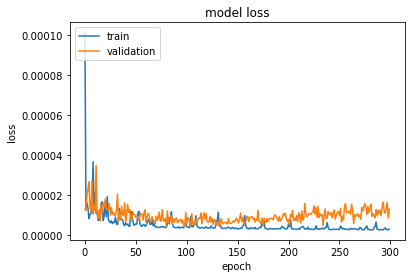

In [427]:
# C.Evaluating the decrease of the model loss, we may need more epochs

print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
When we read this graph, we realize that we are overfitting the dataset 

In [435]:
prediction_unscaled=scaler_y.inverse_transform(predictions)

print('mse: ',mean_squared_error(y_val, prediction_unscaled))
print('mae: ',mean_absolute_error(y_val, prediction_unscaled))
print('r2score: ',r2_score(y_val, prediction_unscaled))

mse:  403.3497551120718
mae:  3.9888812448710955
r2score:  0.8550596127080312


## 2.2. Simpler model : 1 hidden layer, and less neurones in the hidden layer 

In [521]:
# A. Setting up the model
num_features=x.shape[1]
hidden_layers=2/3*(num_features+1)

simpler_model = Sequential()
simpler_model.add(Dense(num_features, input_dim=num_features, kernel_initializer='normal', activation='relu'))
simpler_model.add(Dense(hidden_layers, activation='relu'))
simpler_model.add(Dense(1, activation='linear'))
simpler_model.summary()

Model: "sequential_54"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_165 (Dense)            (None, 86)                7482      
_________________________________________________________________
dense_166 (Dense)            (None, 58)                5046      
_________________________________________________________________
dense_167 (Dense)            (None, 1)                 59        
Total params: 12,587
Trainable params: 12,587
Non-trainable params: 0
_________________________________________________________________


In [522]:
# B. Fitting the model

epoch=250
batch=2500

simpler_model.compile(loss='mse', optimizer='adam', metrics=['mse','mae']) # mean_squared_error (mse) and mean_absolute_error (mae) are our loss functions
history=simpler_model.fit(xtrain_scale, ytrain_scale, epochs=epoch, batch_size=batch, verbose=0, validation_split=0.2)
predictions = simpler_model.predict(xval_scale)

dict_keys(['loss', 'mse', 'mae', 'val_loss', 'val_mse', 'val_mae'])


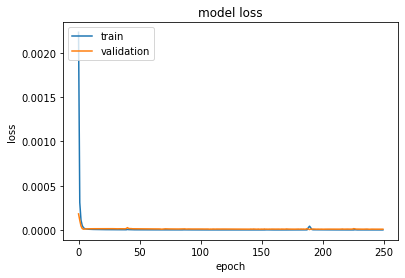

In [523]:
# C.Evaluating the decrease of the model loss

print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [524]:
prediction_unscaled=scaler_y.inverse_transform(predictions)

print('mse: ',mean_squared_error(y_val, prediction_unscaled))
print('mae: ',mean_absolute_error(y_val, prediction_unscaled))
print('r2score: ',r2_score(y_val, prediction_unscaled))

mse:  398.42176576899215
mae:  4.77668922531441
r2score:  0.8568304447834298


## How did we set-up the parameters ?

We used as base parameters the best fit for the last model, and we changed them one by one until we found the best value for each, using a dichotomy method. If the curb was not looking well, we knew even before looking at the indicators that we were overfitting.
   
For epoch, we went from 100 to 200 and then 300, we realized that for 300 the value of the indicators (mse, mae and r2score) were decreasing, so we tested 250. Since 250 was even better than 200, we kept this value for epoch.

Then, we did the same for the batch, starting at int(x.shape[0]/10)=4610. 5000 was less performant, so we went the other way, decreasing the batch size. We tested 3000, 2000 and 1000. 1000 had the best results for the indicators, but the graph shown a beggining of overfitting. So we went back to the last best value : 3000 and we ajusted it a bit. We finally land at batch=2500.

To be sure that we have a nice couple (batch, epoch), we try other values of epoch with fixed batch, and we finally ended again at epoch=250.

In [559]:
# D. Analysis of the results

#we create a new dataset with the predictions, and the real values
comparison=pd.concat([pd.DataFrame(prediction_unscaled).rename(columns={0:'prediction'}),pd.DataFrame(y_val).rename(columns={0:'y_val'})],axis=1)

comparison.head(10)

,prediction,y_val
0,17.395487,21
1,0.698987,0
2,0.440625,0
3,36.822842,30
4,-0.535815,0
5,10.101364,22
6,2.995779,0
7,1.108929,0
8,0.923328,1
9,2.131805,1


In [526]:
def no_negatives(x):
    if x<0:
        return 0
    return x

comparison['prediction_no_negatives']=comparison['prediction'].apply(lambda x: no_negatives(x))

print('mse: ',mean_squared_error(y_val, comparison['prediction_no_negatives']))
print('mae: ',mean_absolute_error(y_val, comparison['prediction_no_negatives']))
print('r2score: ',r2_score(y_val, comparison['prediction_no_negatives']))

mse:  396.10038360955
mae:  4.387907817772971
r2score:  0.8576646141983802


In [528]:
#we add two new indicators that can help us understand how well the algorithm performs:
comparison['absolute_diff']=comparison.apply(lambda x: math.sqrt((x['prediction']-x['y_val'])**2),axis=1)
comparison['absolute_diff_no_negatives']=comparison.apply(lambda x: math.sqrt((x['prediction_no_negatives']-x['y_val'])**2),axis=1)

comparison.describe()

,prediction,y_val,prediction_no_negatives,absolute_diff,absolute_diff_no_negatives
count,11526.000000,11526.000000,11526.000000,11526.000000,11526.000000
mean,9.374942,9.471022,9.763720,4.776689,4.387908
std,52.163345,52.755170,52.076225,19.381372,19.413381
min,-49.563236,0.000000,0.000000,0.000125,0.000000
25%,-0.181816,0.000000,0.000000,0.647627,0.082181
50%,0.995070,0.000000,0.995070,1.565605,1.000000
75%,3.809610,3.000000,3.809610,3.299275,3.183858
max,2307.578857,2653.000000,2307.578857,533.138519,533.138519


This table allows us to see that with this improvement, we have almost 3/4 of the predictions that are only 3 units away from the real value.

## 2.3. Two hidden layers

Just for fun, we are going to test a neural network with two hidden layers.

In [553]:
# A. Setting up the model
num_features=x.shape[1]
hidden_layers=2/3*(num_features+1)

two_layers_model = Sequential()
two_layers_model.add(Dense(num_features, input_dim=num_features, kernel_initializer='normal', activation='relu'))
two_layers_model.add(Dense(hidden_layers, activation='relu'))
two_layers_model.add(Dense(hidden_layers, activation='relu'))
two_layers_model.add(Dense(1, activation='linear'))
two_layers_model.summary()

Model: "sequential_61"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_192 (Dense)            (None, 86)                7482      
_________________________________________________________________
dense_193 (Dense)            (None, 58)                5046      
_________________________________________________________________
dense_194 (Dense)            (None, 58)                3422      
_________________________________________________________________
dense_195 (Dense)            (None, 1)                 59        
Total params: 16,009
Trainable params: 16,009
Non-trainable params: 0
_________________________________________________________________


In [554]:
# B. Fitting the model

epoch=180
batch=2500

two_layers_model.compile(loss='mse', optimizer='adam', metrics=['mse','mae']) # mean_squared_error (mse) and mean_absolute_error (mae) are our loss functions
history=two_layers_model.fit(xtrain_scale, ytrain_scale, epochs=epoch, batch_size=batch, verbose=0, validation_split=0.2)
predictions = two_layers_model.predict(xval_scale)

dict_keys(['loss', 'mse', 'mae', 'val_loss', 'val_mse', 'val_mae'])


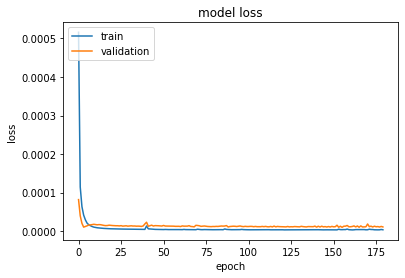

In [555]:
# C.Evaluating the decrease of the model loss

print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [556]:
prediction_unscaled=scaler_y.inverse_transform(predictions)

print('mse: ',mean_squared_error(y_val, prediction_unscaled))
print('mae: ',mean_absolute_error(y_val, prediction_unscaled))
print('r2score: ',r2_score(y_val, prediction_unscaled))

mse:  382.29655333078347
mae:  4.62668728646888
r2score:  0.8626249060576405


With two hidden layers, we slightly increase the performance of our Neural Network.

As we did for the 1-hidden layer neural network, we can increase the performance by replacing the negative predictions by zeros.

In [560]:
comparison=pd.concat([pd.DataFrame(prediction_unscaled).rename(columns={0:'prediction'}),pd.DataFrame(y_val).rename(columns={0:'y_val'})],axis=1)
comparison['prediction_no_negatives']=comparison['prediction'].apply(lambda x: no_negatives(x))

print('mse: ',mean_squared_error(y_val, comparison['prediction_no_negatives']))
print('mae: ',mean_absolute_error(y_val, comparison['prediction_no_negatives']))
print('r2score: ',r2_score(y_val, comparison['prediction_no_negatives']))

mse:  381.1312276346162
mae:  4.430422886162698
r2score:  0.8630436561760751


# Conclusion

To conclude this section, we can say that the Neural Networks are a perfectly suited tool to predict the number of insults in Youtube comments. 
We can get very reasonable results using a classic one hidden layer network, or create a more complex one with more networks, which means it will be more expensive to train it, for slightly better results.

# Bonus just for fun : what overfitting would look like here

Bellow is an example of overfitting we found during our investigations

In [575]:
# A. Setting up the model
num_features=x.shape[1]
hidden_layers=2/3*(num_features+1)

simpler_model = Sequential()
simpler_model.add(Dense(num_features, input_dim=num_features, kernel_initializer='normal', activation='relu'))
simpler_model.add(Dense(hidden_layers, activation='relu'))
simpler_model.add(Dense(1, activation='linear'))
simpler_model.summary()

Model: "sequential_65"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_206 (Dense)            (None, 86)                7482      
_________________________________________________________________
dense_207 (Dense)            (None, 58)                5046      
_________________________________________________________________
dense_208 (Dense)            (None, 1)                 59        
Total params: 12,587
Trainable params: 12,587
Non-trainable params: 0
_________________________________________________________________


In [576]:
# B. Running the model
epoch=300
batch=100

simpler_model.compile(loss='mse', optimizer='adam', metrics=['mse','mae']) # mean_squared_error (mse) and mean_absolute_error (mae) are our loss functions
history=simpler_model.fit(xtrain_scale, ytrain_scale, epochs=epoch, batch_size=batch, verbose=0, validation_split=0.2)
predictions = simpler_model.predict(xval_scale)

dict_keys(['loss', 'mse', 'mae', 'val_loss', 'val_mse', 'val_mae'])


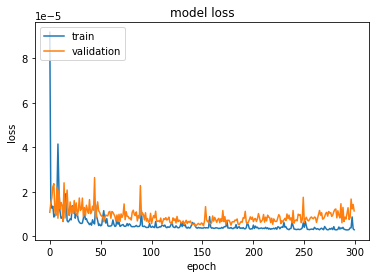

In [577]:
# C.Evaluating the decrease of the model loss, we may need more epochs

print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [579]:
prediction_unscaled=scaler_y.inverse_transform(predictions)

print('mse: ',mean_squared_error(y_val, prediction_unscaled))
print('mae: ',mean_absolute_error(y_val, prediction_unscaled))
print('r2score: ',r2_score(y_val, prediction_unscaled))

mse:  448.730279613069
mae:  4.417877873299236
r2score:  0.8387524978199619


Even though the indicators are high for this neural network, the chart (on cell B.) highlights the problem of overfitting we are facing here : even when we increase the number of epochs, the neural network fails to decrease the validation loss.